In [1]:
import pandas as pd, numpy as np, os
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir ='/ihme/costeffectiveness/results/vivarium_ciff_sam/v6.0.1_vicious_cycle/ciff_sam/2022_02_23_17_26_53/count_data/'

In [3]:
figname = 'model_6.0.1'

In [4]:
os.listdir(output_dir)

['wasting_transition_count.hdf',
 'wasting_transition_count.csv',
 'wasting_state_person_time.hdf',
 'deaths.csv',
 'wasting_state_person_time.csv',
 'deaths.hdf',
 'disease_transition_count.csv',
 'births.csv',
 'population.csv',
 'stunting_state_person_time.hdf',
 'ylds.csv',
 'ylls.csv',
 'disease_state_person_time.csv',
 'population.hdf',
 'ylls.hdf',
 'ylds.hdf',
 'disease_state_person_time.hdf',
 'births.hdf',
 'disease_transition_count.hdf',
 'stunting_state_person_time.csv']

In [5]:
state_pt = pd.read_csv(output_dir + 'disease_state_person_time.csv')
transitions = pd.read_csv(output_dir + 'disease_transition_count.csv')
deaths = pd.read_csv(output_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,0,female,2022,diarrheal_diseases,death,29,baseline,1.0,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,diarrheal_diseases,death,29,baseline,0.0,mild_child_wasting,early_neonatal
2,2,female,2022,diarrheal_diseases,death,29,baseline,0.0,moderate_acute_malnutrition,early_neonatal
3,3,female,2022,diarrheal_diseases,death,29,baseline,1.0,severe_acute_malnutrition,early_neonatal
4,4,female,2022,diarrheal_diseases,death,29,baseline,3.0,susceptible_to_child_wasting,late_neonatal


In [6]:
state_pt

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,wasting_state,age
0,0,female,2022,diarrheal_diseases,state_person_time,29,baseline,2.758385,susceptible_to_child_wasting,early_neonatal
1,1,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.717317,mild_child_wasting,early_neonatal
2,2,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.203970,moderate_acute_malnutrition,early_neonatal
3,3,female,2022,diarrheal_diseases,state_person_time,29,baseline,0.067077,severe_acute_malnutrition,early_neonatal
4,4,female,2022,diarrheal_diseases,state_person_time,29,baseline,16.243669,susceptible_to_child_wasting,late_neonatal
...,...,...,...,...,...,...,...,...,...,...
69115,69115,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,189.771389,severe_acute_malnutrition,12_to_23_months
69116,69116,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,23136.283368,susceptible_to_child_wasting,2_to_4
69117,69117,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,6735.074606,mild_child_wasting,2_to_4
69118,69118,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1822.220397,moderate_acute_malnutrition,2_to_4


In [7]:
groupby_cols = ['input_draw','wasting_state']

In [8]:
def calculate_transition_rates(groupby_cols):
    trans = transitions.loc[transitions.scenario=='baseline']
    trans['cause'] = trans['measure'].str.split('to_', expand=True)[2].str.split('_event_count', expand=True)[0]
    trans['measure'] = np.where(trans.measure.str.contains('to_susceptible_to'),'remission','incidence')
    trans = trans.groupby(groupby_cols+['cause','measure']).sum()
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
          .loc[state_pt.scenario=='baseline']
          .groupby(groupby_cols).sum())
    trans = (trans / pt)[['value']]
    trans = trans#.groupby([c for c in groupby_cols if c != 'input_draw'] + ['cause','measure']).describe(percentiles=[0.025,0.975])
    return trans

In [9]:
def calculate_incidence_rrs(strata_cols):
    t = calculate_transition_rates(strata_cols + ['input_draw','wasting_state']).reset_index()
    t = t.loc[t.measure=='incidence']
    tmrel = t.loc[t.wasting_state=='susceptible_to_child_wasting'].set_index(strata_cols + ['input_draw','cause'])[['value']]
    t = t.set_index(strata_cols + ['input_draw','cause','wasting_state'])[['value']] / tmrel
    t = t.groupby(strata_cols + ['cause','wasting_state']).describe(percentiles=[0.025,0.975])
    return t

In [10]:
calculate_incidence_rrs([])

value            \
                                                          count      mean   
cause                        wasting_state                                  
diarrheal_diseases           mild_child_wasting            12.0  1.007920   
                             moderate_acute_malnutrition   12.0  1.049743   
                             severe_acute_malnutrition     12.0  1.124516   
                             susceptible_to_child_wasting  12.0  1.000000   
lower_respiratory_infections mild_child_wasting            12.0  1.875697   
                             moderate_acute_malnutrition   12.0  4.317996   
                             severe_acute_malnutrition     12.0  8.456475   
                             susceptible_to_child_wasting  12.0  1.000000   
measles                      mild_child_wasting            12.0  1.060185   
                             moderate_acute_malnutrition   12.0  2.527310   
                             severe_acute_malnutrition     12.0  8.521764   
                             susceptible_to_child_wasting  12.0  1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            0.003398  1.000972   
                             moderate_acute_malnutrition   0.013118  1.026435   
                             severe_acute_malnutrition     0.024512  1.083643   
                             susceptible_to_child_wasting  0.000000  1.000000   
lower_respiratory_infections mild_child_wasting            0.356450  1.358195   
                             moderate_acute_malnutrition   0.883410  3.041344   
                             severe_acute_malnutrition     2.316020  5.597117   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.187956  0.831499   
                             moderate_acute_malnutrition   0.493767  1.595425   
                             severe_acute_malnutrition     2.473014  4.828926   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                               \
                                                               2.5%       50%   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            1.001279  1.008535   
                             moderate_acute_malnutrition   1.029653  1.051586   
                             severe_acute_malnutrition     1.088447  1.117330   
                             susceptible_to_child_wasting  1.000000  1.000000   
lower_respiratory_infections mild_child_wasting            1.382169  1.783300   
                             moderate_acute_malnutrition   3.067045  4.185992   
                             severe_acute_malnutrition     5.655369  8.296376   
                             susceptible_to_child_wasting  1.000000  1.000000   
measles                      mild_child_wasting            0.847149  0.982838   
                             moderate_acute_malnutrition   1.650907  2.469474   
                             severe_acute_malnutrition     5.147307  8.975482   
                             susceptible_to_child_wasting  1.000000  1.000000   

                                                                      \
                                                               97.5%   
cause                        wasting_state                             
diarrheal_diseases           mild_child_wasting             1.012430   
                             moderate_acute_malnutrition    1.071855   
                             severe_acute_malnutrition      1.161761   
                             susceptib

In [11]:
incidence_rrs = calculate_incidence_rrs(['age','sex'])
incidence_rrs

value  \
                                                                               count   
age           sex    cause                        wasting_state                        
1-5_months    female diarrheal_diseases           mild_child_wasting            12.0   
                                                  moderate_acute_malnutrition   12.0   
                                                  severe_acute_malnutrition     12.0   
                                                  susceptible_to_child_wasting  12.0   
                     lower_respiratory_infections mild_child_wasting            12.0   
...                                                                              ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  12.0   
                     measles                      mild_child_wasting             0.0   
                                                  moderate_acute_malnutrition    0.0   
                                                  severe_acute_malnutrition      0.0   
                                                  susceptible_to_child_wasting   0.0   

                                                                                          \
                                                                                    mean   
age           sex    cause                        wasting_state                            
1-5_months    female diarrheal_diseases           mild_child_wasting            1.000590   
                                                  moderate_acute_malnutrition   0.997291   
                                                  severe_acute_malnutrition     0.997170   
                                                  susceptible_to_child_wasting  1.000000   
                     lower_respiratory_infections mild_child_wasting            1.022266   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  1.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     std   
age           sex    cause                        wasting_state                            
1-5_months    female diarrheal_diseases           mild_child_wasting            0.006141   
                                                  moderate_acute_malnutrition   0.017431   
                                                  severe_acute_malnutrition     0.029276   
                                                  susceptible_to_child_wasting  0.000000   
                     lower_respiratory_infections mild_child_wasting            0.070266   
...                                                                                  ...   
late_neonatal male   lower_respiratory_infections susceptible_to_child_wasting  0.000000   
                     measles                      mild_child_wasting                 NaN   
                                                  moderate_acute_malnutrition        NaN   
                                                  severe_acute_malnutrition          NaN   
                                                  susceptible_to_child_wasting       NaN   

                                                                                          \
                                                                                     min   
age           sex    cause                        wasting_state                     

In [12]:
# artifact
from vivarium import Artifact
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf',
               filter_terms=['year_start == 2020', f'age_end <= 5'])

In [13]:
wasting_rrs = art.load('risk_factor.child_wasting.relative_risk')

In [14]:
wasting_rrs = (art.load('risk_factor.child_wasting.relative_risk')
               .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
               .reset_index())
wasting_rrs['age'] = np.where(wasting_rrs['age_start'] == 0, 'early_neonatal', #1
                                            np.where(wasting_rrs['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(wasting_rrs['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(wasting_rrs['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(wasting_rrs['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2

wasting_rrs.head()

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,parameter,count,mean,std,min,2.5%,50%,97.5%,max,age
0,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
1,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat2,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
2,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat3,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
3,Female,0.0,0.019178,2020,2021,diarrheal_diseases,excess_mortality_rate,cat4,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal
4,Female,0.0,0.019178,2020,2021,lower_respiratory_infections,incidence_rate,cat1,1000.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,early_neonatal


In [15]:
def plot_incidence_relative_risks(age, sex, cause, measure):
    width=0.4
    if measure == 'incidence_rate':
        s = incidence_rrs.reset_index()
    elif measure == 'CSMR':
        s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

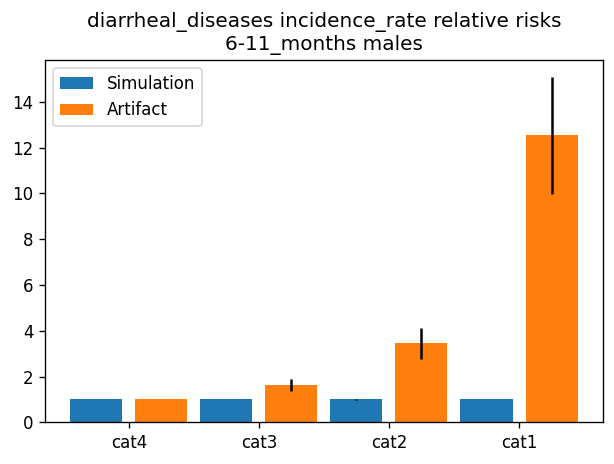

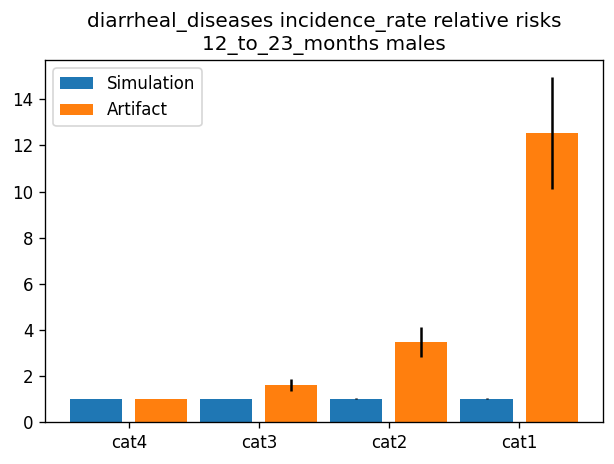

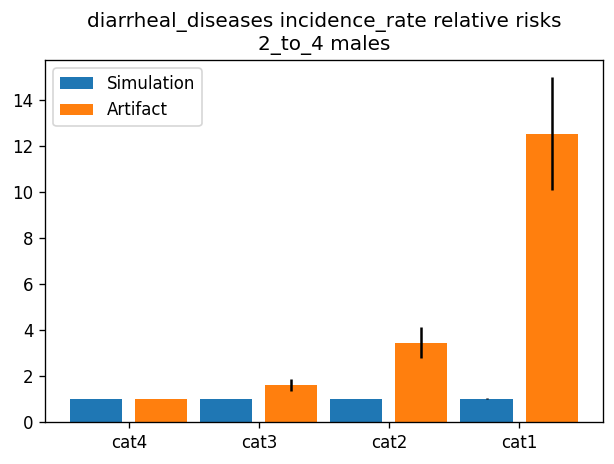

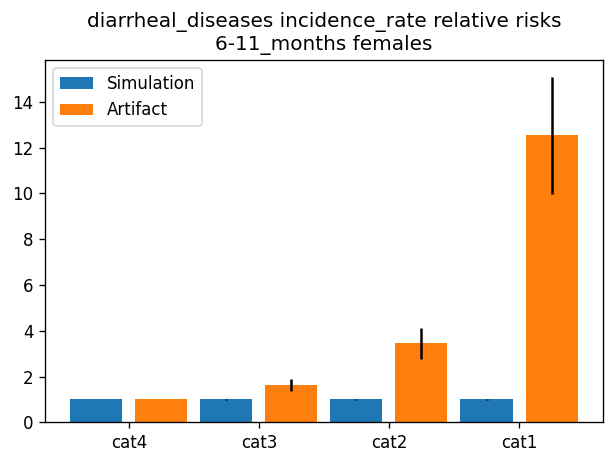

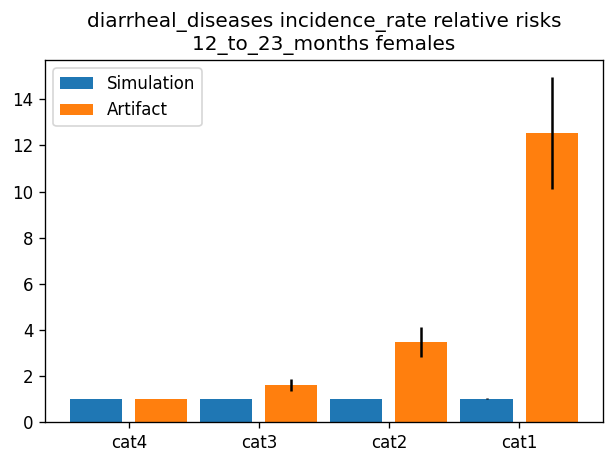

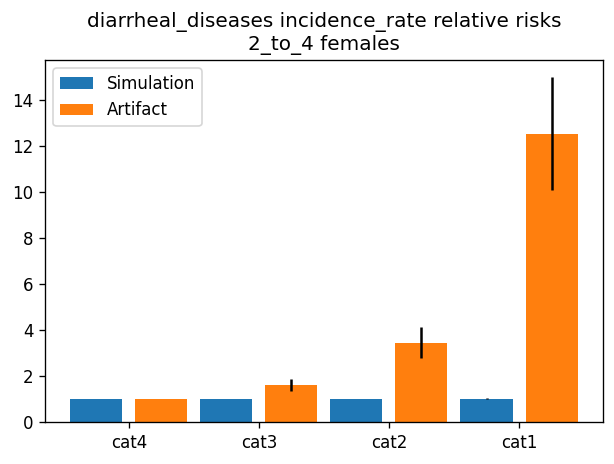

In [16]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'diarrheal_diseases', 'incidence_rate')

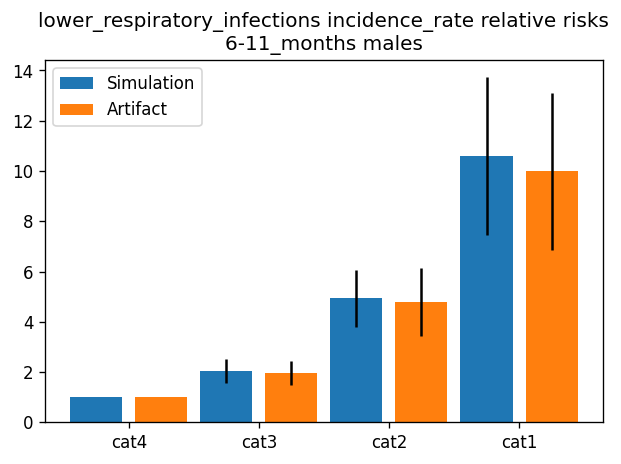

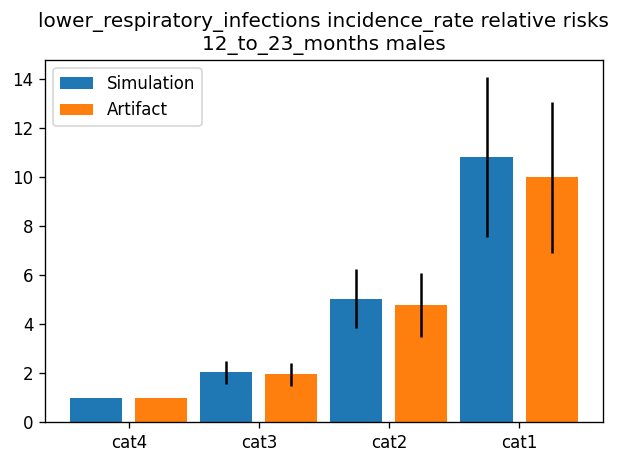

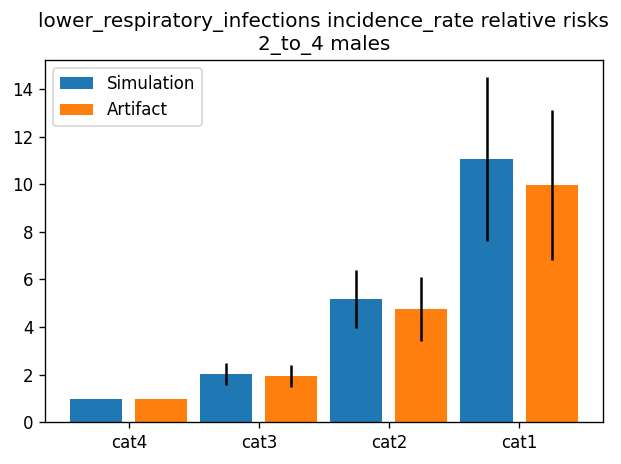

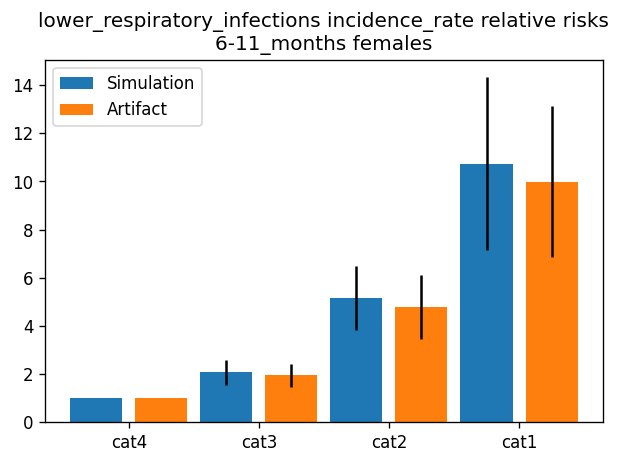

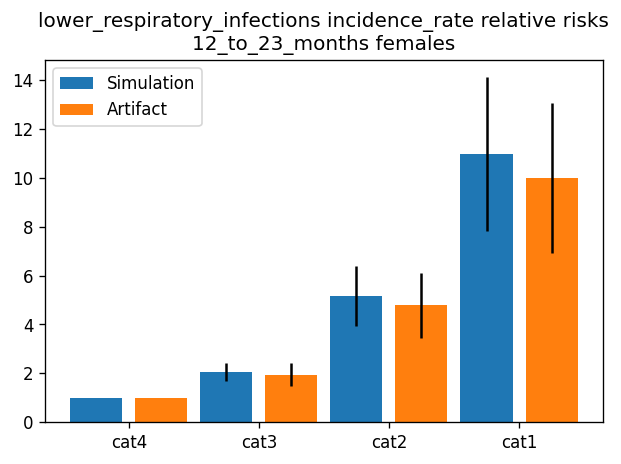

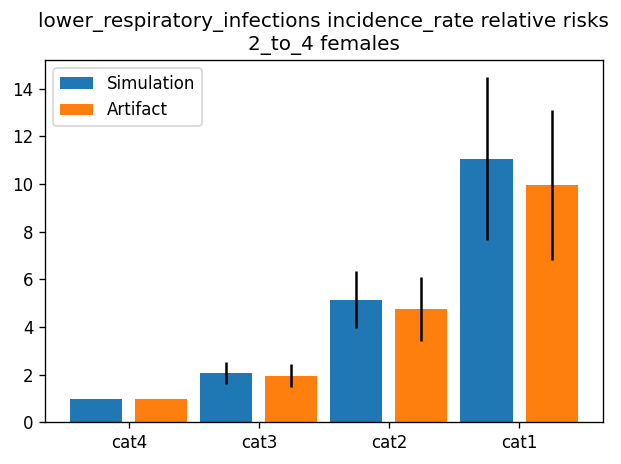

In [17]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'incidence_rate')

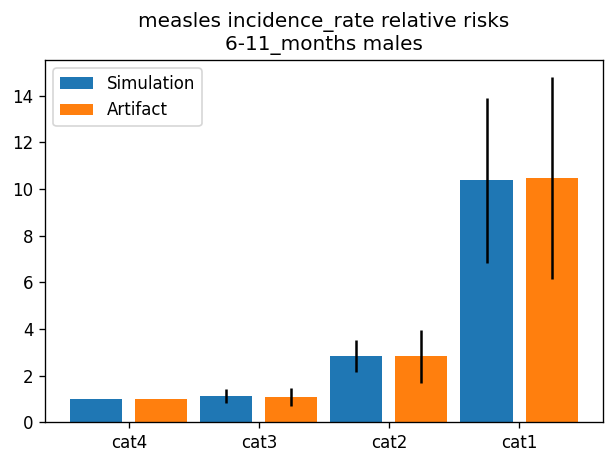

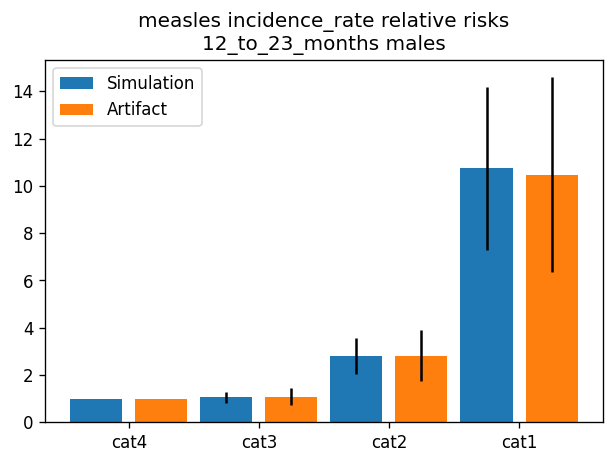

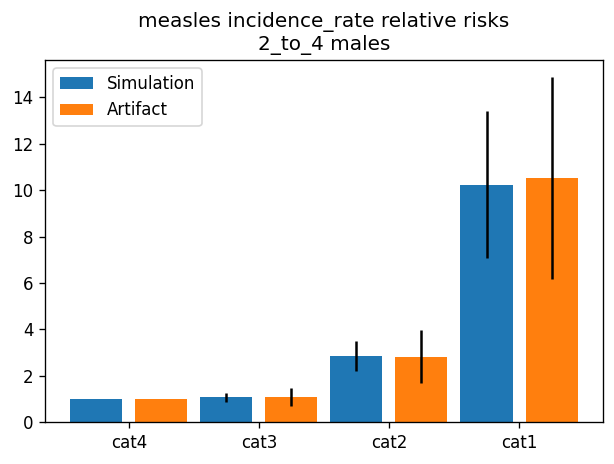

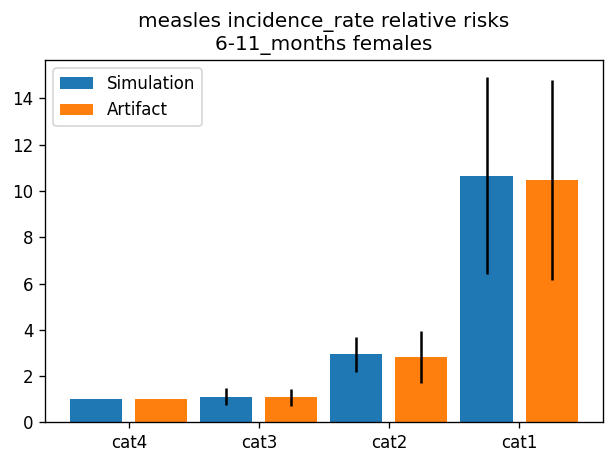

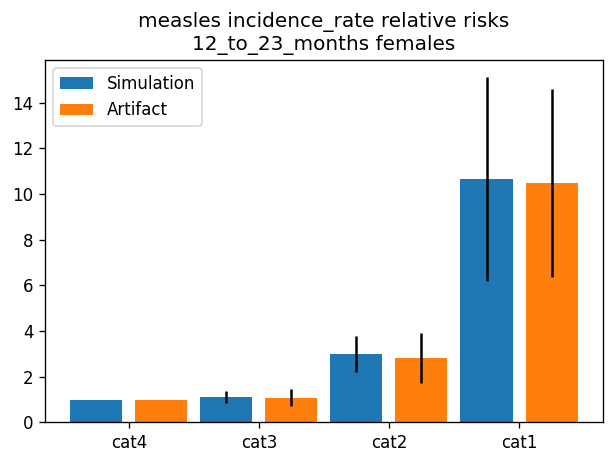

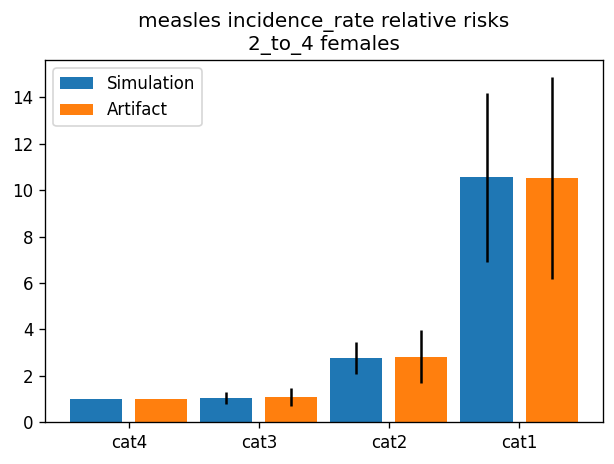

In [18]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'measles', 'incidence_rate')

In [19]:
def calculate_csmr_rrs(strata_cols):
    d = deaths.reset_index()
    d = d.loc[(d.scenario=='baseline')
             &(d.cause.isin(['diarrheal_diseases',
                            'lower_respiratory_infections',
                            'measles']))
             #&(d.age.isin(['12_to_23_months','2_to_4']))
             ]
    d = d.groupby(strata_cols + ['input_draw','wasting_state','cause']).sum()[['value']]
    pt = (state_pt.loc[state_pt.cause.str.contains('measles')]
              .loc[(state_pt.scenario=='baseline')]
              .groupby(strata_cols + ['input_draw','wasting_state']).sum())[['value']]
    d = (d / pt).reset_index()
    d_tmrel = d.loc[d.wasting_state.str.contains('susc')].set_index(strata_cols + ['input_draw','cause'])[['value']]
    d = d.set_index(strata_cols + ['input_draw','cause','wasting_state']) / d_tmrel
    d = d.groupby(strata_cols + ['cause','wasting_state']).describe()
    return d

In [20]:
calculate_csmr_rrs([])

value             \
                                                          count       mean   
cause                        wasting_state                                   
diarrheal_diseases           mild_child_wasting            12.0   1.682244   
                             moderate_acute_malnutrition   12.0   5.020219   
                             severe_acute_malnutrition     12.0  12.730177   
                             susceptible_to_child_wasting  12.0   1.000000   
lower_respiratory_infections mild_child_wasting            12.0   1.511031   
                             moderate_acute_malnutrition   12.0   3.063224   
                             severe_acute_malnutrition     12.0   6.829641   
                             susceptible_to_child_wasting  12.0   1.000000   
measles                      mild_child_wasting            12.0   1.175511   
                             moderate_acute_malnutrition   12.0   2.309270   
                             severe_acute_malnutrition     12.0   8.107143   
                             susceptible_to_child_wasting  12.0   1.000000   

                                                                               \
                                                                std       min   
cause                        wasting_state                                      
diarrheal_diseases           mild_child_wasting            0.272479  1.323950   
                             moderate_acute_malnutrition   1.192847  3.411847   
                             severe_acute_malnutrition     3.643657  6.659917   
                             susceptible_to_child_wasting  0.000000  1.000000   
lower_respiratory_infections mild_child_wasting            0.239408  1.120054   
                             moderate_acute_malnutrition   0.421890  2.413933   
                             severe_acute_malnutrition     2.168612  3.389632   
                             susceptible_to_child_wasting  0.000000  1.000000   
measles                      mild_child_wasting            0.390596  0.636767   
                             moderate_acute_malnutrition   0.715141  1.423824   
                             severe_acute_malnutrition     3.166481  3.729554   
                             susceptible_to_child_wasting  0.000000  1.000000   

                                                                     \
                                                                25%   
cause                        wasting_state                            
diarrheal_diseases           mild_child_wasting            1.447164   
                             moderate_acute_malnutrition   4.158238   
                             severe_acute_malnutrition     9.155730   
                             susceptible_to_child_wasting  1.000000   
lower_respiratory_infections mild_child_wasting            1.362414   
                             moderate_acute_malnutrition   2.748241   
                             severe_acute_malnutrition     5.396866   
                             susceptible_to_child_wasting  1.000000   
measles                      mild_child_wasting            0.844551   
                             moderate_acute_malnutrition   1.793148   
                             severe_acute_malnutrition     6.291203   
                             susceptible_to_child_wasting  1.000000   

                                                                      \
                                                                 50%   
cause                        wasting_state                             
diarrheal_diseases           mild_child_wasting             1.662794   
                             moderate_acute_malnutrition    4.843300   
                             severe_acute_malnutrition     13.325263   
                             susceptible_to_child_wasting   1.000000   
lower_respiratory_infections mild_child_wasting             1.499144   
                             

In [21]:
csmr_rrs = calculate_csmr_rrs(['age','sex'])
csmr_rrs.head()

value  \
                                                                            count   
age        sex    cause                        wasting_state                        
1-5_months female diarrheal_diseases           mild_child_wasting            12.0   
                                               moderate_acute_malnutrition   12.0   
                                               severe_acute_malnutrition     12.0   
                                               susceptible_to_child_wasting  12.0   
                  lower_respiratory_infections mild_child_wasting            12.0   

                                                                                       \
                                                                                 mean   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            1.062009   
                                               moderate_acute_malnutrition   0.989414   
                                               severe_acute_malnutrition     0.926415   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            1.235256   

                                                                                       \
                                                                                  std   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.300816   
                                               moderate_acute_malnutrition   0.616913   
                                               severe_acute_malnutrition     1.078226   
                                               susceptible_to_child_wasting  0.000000   
                  lower_respiratory_infections mild_child_wasting            0.520994   

                                                                                       \
                                                                                  min   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.381894   
                                               moderate_acute_malnutrition   0.217679   
                                               severe_acute_malnutrition     0.000000   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            0.471133   

                                                                                       \
                                                                                  25%   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            0.887618   
                                               moderate_acute_malnutrition   0.555344   
                                               severe_acute_malnutrition     0.000000   
                                               susceptible_to_child_wasting  1.000000   
                  lower_respiratory_infections mild_child_wasting            0.858866   

                                                                                       \
                                                                                  50%   
age        sex    cause                        wasting_state                            
1-5_months female diarrheal_diseases           mild_child_wasting            1.140690   
                                               moderate_acute_malnutrition   0.750569   
                                               severe_acute_malnutrition     0.505659   
         

In [22]:
def plot_csmr_relative_risks(age, sex, cause, measure):
    width=0.4
    s = csmr_rrs.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             &(s.cause==cause)]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

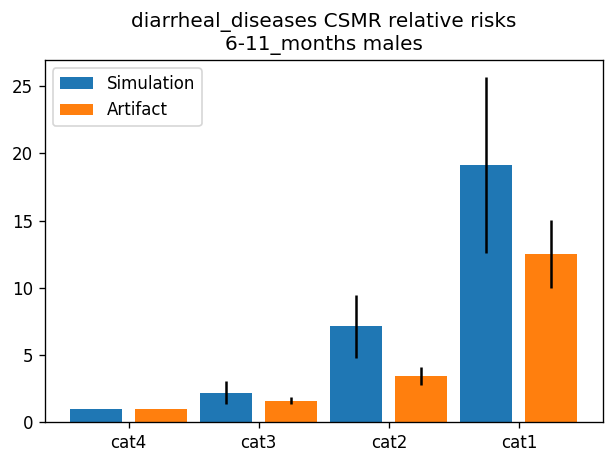

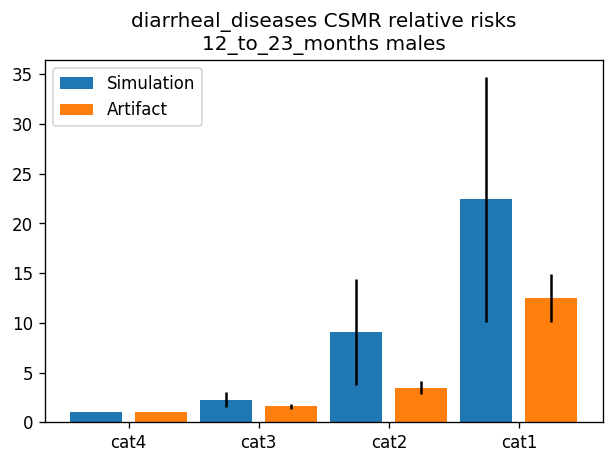

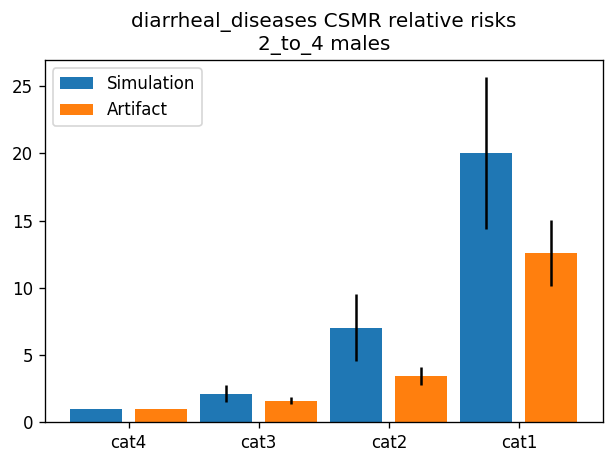

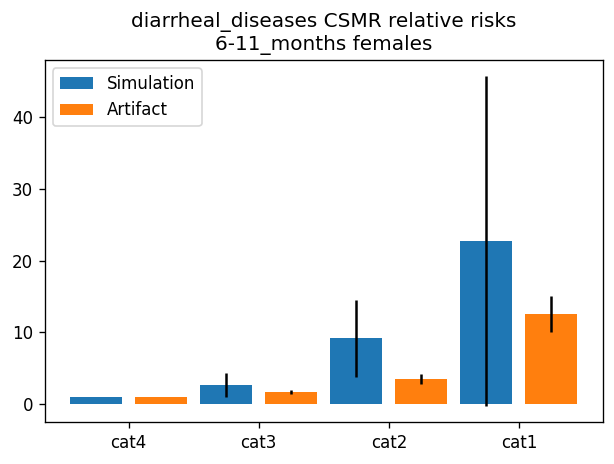

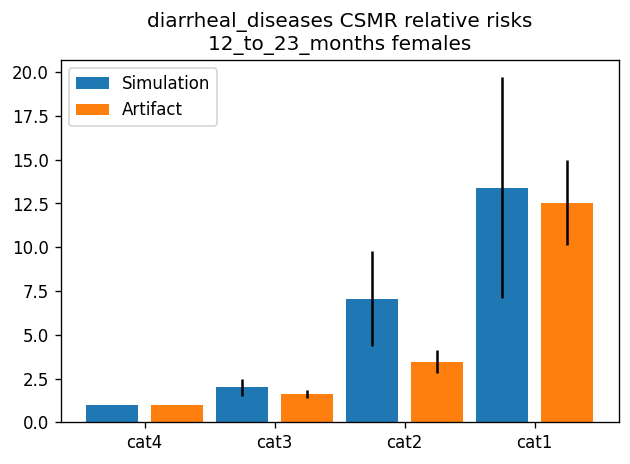

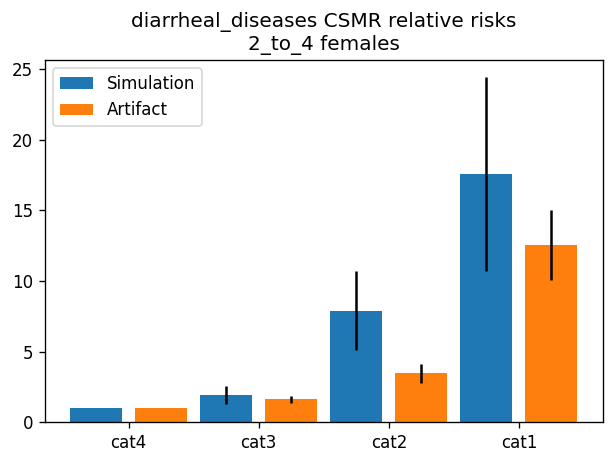

In [23]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'diarrheal_diseases', 'CSMR')

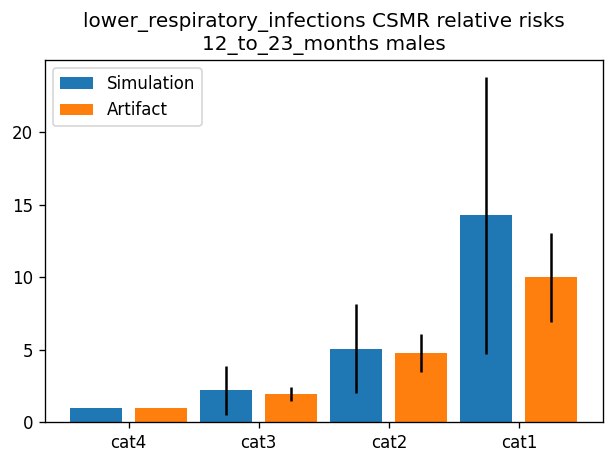

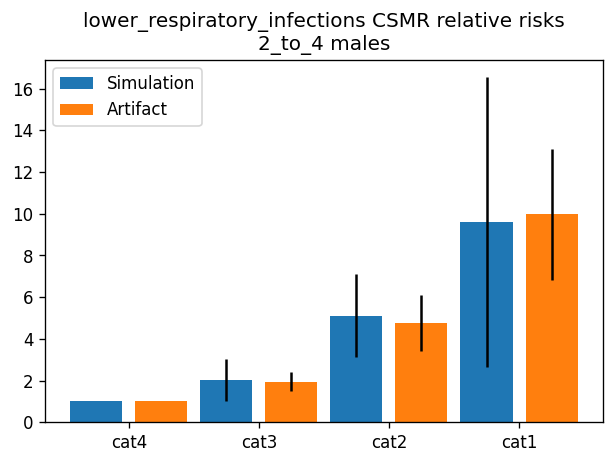

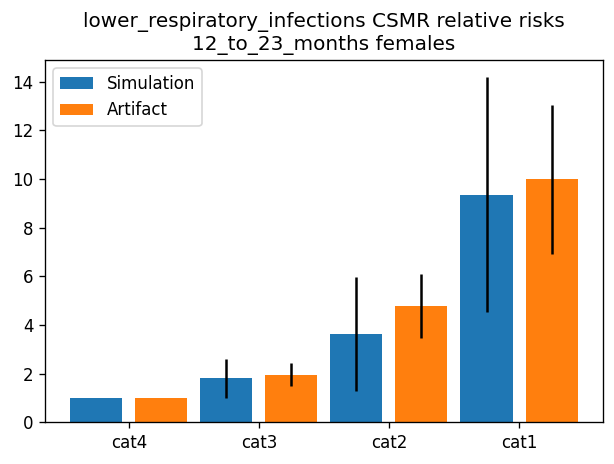

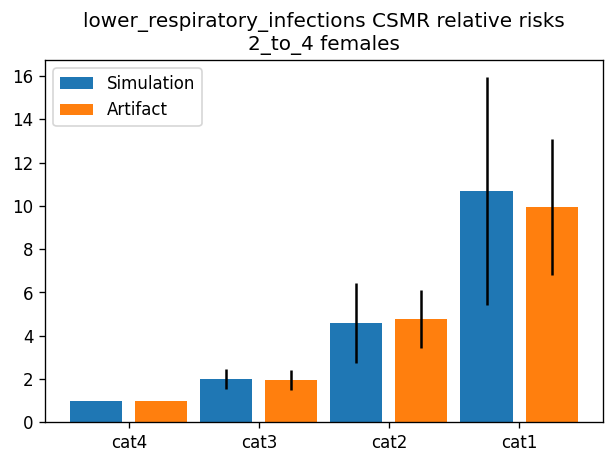

In [24]:
for sex in ['male','female']:
    for age in ['12_to_23_months','2_to_4']:
            plot_incidence_relative_risks(age, sex, 'lower_respiratory_infections', 'CSMR')

# so now EMRs

In [25]:
d = deaths.reset_index()
d = d.loc[(d.scenario=='baseline')&(d.cause=='diarrheal_diseases')]
d = d.groupby(['input_draw','sex','age','wasting_state']).sum()[['value']]
pt = state_pt.loc[(state_pt.cause=='diarrheal_diseases')
                 &(state_pt.scenario=='baseline')]
pt = pt.groupby(['input_draw','sex','age','wasting_state']).sum()[['value']]
emr = d/pt
emr_tmrel = (emr.reset_index().loc[emr.reset_index().wasting_state=='susceptible_to_child_wasting']
             .set_index(['input_draw','sex','age'])[['value']])
diarrhea_emr_rr = emr / emr_tmrel
diarrhea_emr_rr = diarrhea_emr_rr.groupby(['sex','age','wasting_state']).describe()
diarrhea_emr_rr.head()

value                      \
                                                    count      mean       std   
sex    age             wasting_state                                            
female 1-5_months      mild_child_wasting            12.0  1.060973  0.299205   
                       moderate_acute_malnutrition   12.0  0.994068  0.623457   
                       severe_acute_malnutrition     12.0  0.917799  1.061924   
                       susceptible_to_child_wasting  12.0  1.000000  0.000000   
       12_to_23_months mild_child_wasting            12.0  1.679664  0.411303   

                                                                         \
                                                          min       25%   
sex    age             wasting_state                                      
female 1-5_months      mild_child_wasting            0.381324  0.893314   
                       moderate_acute_malnutrition   0.221727  0.556004   
                       severe_acute_malnutrition     0.000000  0.000000   
                       susceptible_to_child_wasting  1.000000  1.000000   
       12_to_23_months mild_child_wasting            0.915768  1.414253   

                                                                         \
                                                          50%       75%   
sex    age             wasting_state                                      
female 1-5_months      mild_child_wasting            1.133029  1.249773   
                       moderate_acute_malnutrition   0.756060  1.245840   
                       severe_acute_malnutrition     0.494212  1.823406   
                       susceptible_to_child_wasting  1.000000  1.000000   
       12_to_23_months mild_child_wasting            1.745236  1.884138   

                                                               
                                                          max  
sex    age             wasting_state                           
female 1-5_months      mild_child_wasting            1.511158  
                       moderate_acute_malnutrition   2.461640  
                       severe_acute_malnutrition     2.693714  
                       susceptible_to_child_wasting  1.000000  
       12_to_23_months mild_child_wasting            2.381798

In [26]:
def plot_emr_rrs(age, sex):
    width=0.4
    measure = 'EMR'
    cause = 'diarrheal_diseases'
    s = diarrhea_emr_rr.reset_index()
    s = s.loc[(s.sex==sex)
             &(s.age==age)
             #&(s.cause==cause)
             ]

    s['order'] = np.where(s.wasting_state.str.contains('suscept'), 0,
                         np.where(s.wasting_state.str.contains('mild'), 1,
                                 np.where(s.wasting_state.str.contains('moder'), 2, 3)))
    s = s.sort_values(by='order')
    plt.figure(dpi=120)
    plt.bar([0,1,2,3], s['value','mean'], yerr=s['value','std'], width=width, label='Simulation')

    a = wasting_rrs.reset_index()
    a = a.loc[(a.sex==sex.capitalize())
             &(a.age==age)
             &(a.affected_entity==cause)]

    a = a.sort_values(by='parameter', ascending=False)
    plt.bar([0.5,1.5,2.5,3.5], a['mean'], yerr=a['std'], width=width, label='Artifact')


    plt.title(f'{cause} {measure} relative risks\n{age} {sex}s')
    plt.legend(loc='upper left')
    plt.xticks([0.25, 1.25, 2.25, 3.25], a.parameter)

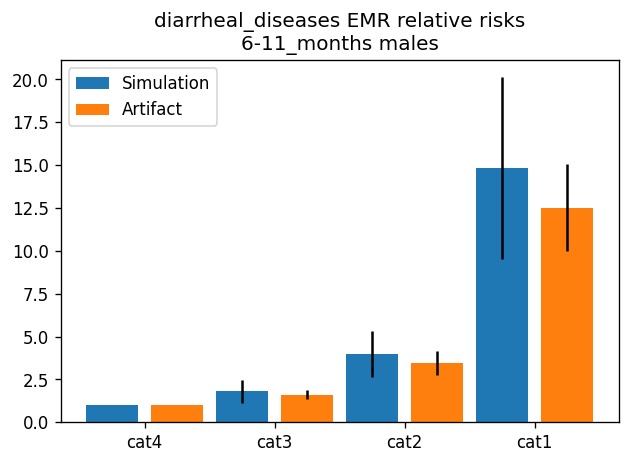

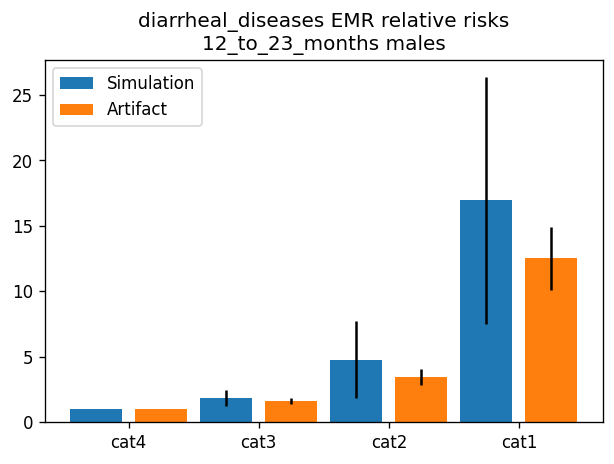

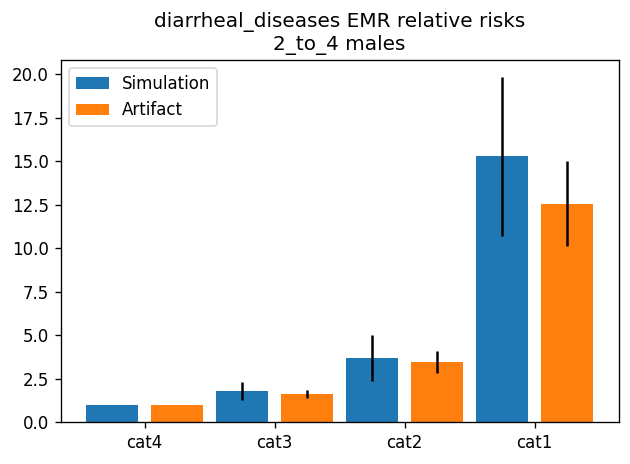

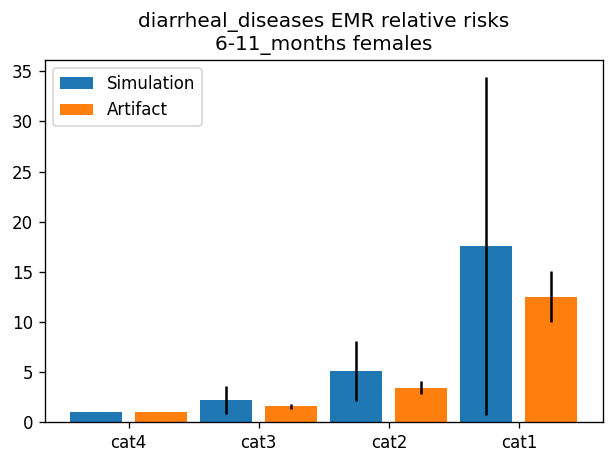

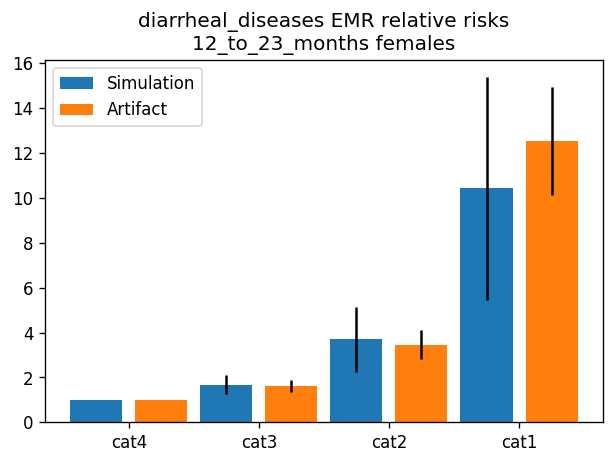

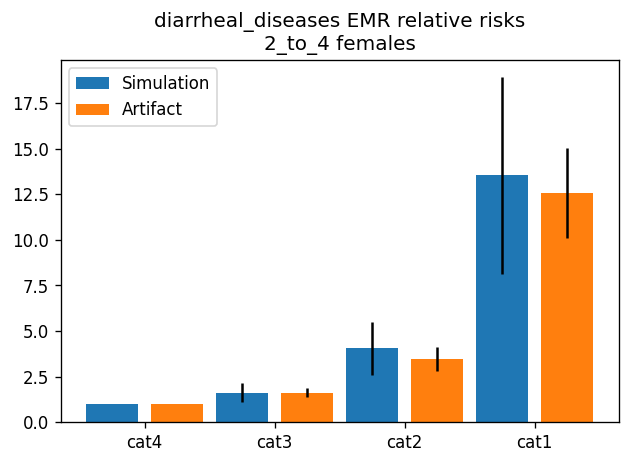

In [27]:
for sex in ['male','female']:
    for age in ['6-11_months','12_to_23_months','2_to_4']:
        plot_emr_rrs(age, sex)